<a href="https://colab.research.google.com/github/YuricgSilva/Pre_Processamento-Filtragem_e_Convolucao_02/blob/main/Pr%C3%A9_Processamento_Filtragem__e__Convolu%C3%A7%C3%A3o_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* **IMPORT`S**

---

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import statistics as st
import pandas as pd
from PIL import Image
from google.colab import drive
from google.colab.patches import cv2_imshow

* **LOAD DATASET**

---

(np.float64(-0.5), np.float64(4079.5), np.float64(3071.5), np.float64(-0.5))

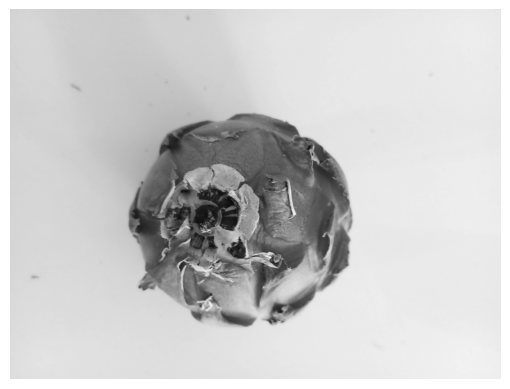

In [6]:
image = cv2.imread(file_path+'0001.jpeg',0)
plt.imshow(image, cmap='gray')
plt.axis('off')

* **FUNÇÃO DE EXIBIÇÃO**

---

In [7]:
def plot_images(original, filtrada):

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Imagem Original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(filtrada, cmap='gray')
    plt.title("Imagem com Filtro")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


* **FUNÇÃO DE BINARIZAÇÃO**

---

In [8]:
def binarizacaoIMG(image, th):
  img = image.copy()
  altura, largura = img.shape
  for i in range(altura):
    for j in range(largura):
      if image[i,j] <= th:
        img[i,j] = 255
      else:
        img[i,j] = 0
  plot_images(image, img)

* **HISTOGRAMA DA IMAGEM**

---

In [9]:
class CalcHistograma:
    def __init__(self, bin_imagem):
        self.imagem = bin_imagem
        self.histograma = np.zeros(256)
        self.largura = bin_imagem.shape[0]
        self.altura = bin_imagem.shape[1]
        self.probabilidade = np.zeros(256, dtype=float)
        self.probabilidade_acc = np.zeros(256, dtype=float)
        self.qtd_pixels = bin_imagem.size
        self.H_equalizado = np.zeros(256, dtype=np.uint8)

    def start(self):
        self.__calcular_frequencia()
        self.__calcular_probabilidade()
        self.__calcular_prob_acc()
        self.__hist_equalizado()

    def __calcular_frequencia(self):
        for i in range(self.largura):
            for j in range(self.altura):
                self.histograma[self.imagem[i][j]] += 1

    def __calcular_probabilidade(self):
        for i in range(256):
            self.probabilidade[i] = self.histograma[i] / self.qtd_pixels

    def __calcular_prob_acc(self):
        aux = 0
        for i in range(256):
            aux += self.probabilidade[i]
            self.probabilidade_acc[i] = aux

    def __hist_equalizado(self):
        L = 255
        step = 1 / (L - 1)
        probabilidade_acc_arredondado = np.zeros(256, dtype=float)
        cdf_levels = np.zeros(256, dtype=float)

        for i in range(cdf_levels.size):
            probabilidade_acc_arredondado[i] = np.round(self.probabilidade_acc[i] / step) * step
            cdf_levels[i] = probabilidade_acc_arredondado[i] * (L - 1)
            self.H_equalizado[i] = round(cdf_levels[i])

    def get_equalized_image(self):
        img_equalizada = np.zeros_like(self.imagem)
        for i in range(self.imagem.shape[0]):
            for j in range(self.imagem.shape[1]):
                img_equalizada[i, j] = self.H_equalizado[self.imagem[i, j]]
        return img_equalizada

    def plot(self, plot_hist=True, plot_equa=True):
        if plot_hist or plot_equa:
            fig, axs = plt.subplots(1, 2, figsize=(8, 3))

            if plot_hist:
                axs[0].bar(range(256), self.histograma, color='gray')
                axs[0].set_title('Histograma Original')
                axs[0].set_xlabel('Níveis (0-255)')
                axs[0].set_ylabel('Qtd. de pixels')
                axs[0].grid(True, linestyle='--', alpha=0.5)

            if plot_equa:
                axs[1].bar(range(256), self.H_equalizado, color='gray')
                axs[1].set_title('Histograma Equalizado')
                axs[1].set_xlabel('Níveis (0-255)')
                axs[1].set_ylabel('Qtd. de pixels')
                axs[1].grid(True, linestyle='--', alpha=0.5)

            plt.tight_layout()
            plt.show()


* **EQUALIZAR IMAGEM**

---

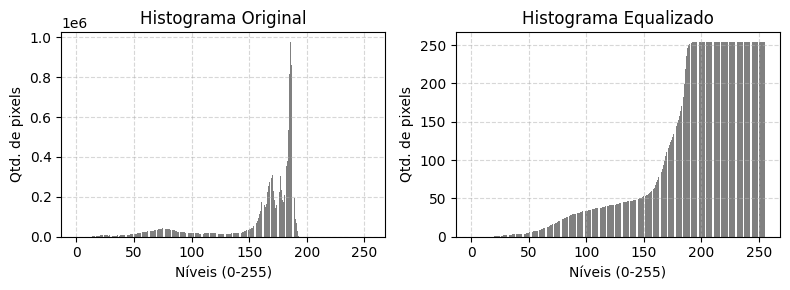

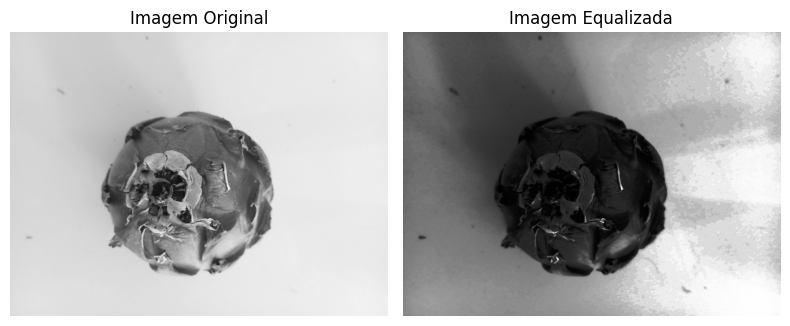

In [10]:
hist = CalcHistograma(image)
hist.start()
hist.plot(plot_hist=True, plot_equa=True)

imagem_equalizada = hist.get_equalized_image()
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Imagem original
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Imagem Original')
axs[0].axis('off')

# Imagem equalizada
axs[1].imshow(imagem_equalizada, cmap='gray')
axs[1].set_title('Imagem Equalizada')
axs[1].axis('off')

plt.tight_layout()
plt.show()

* **THRESHOLDING BASEADO EM PERCENTIL**

---

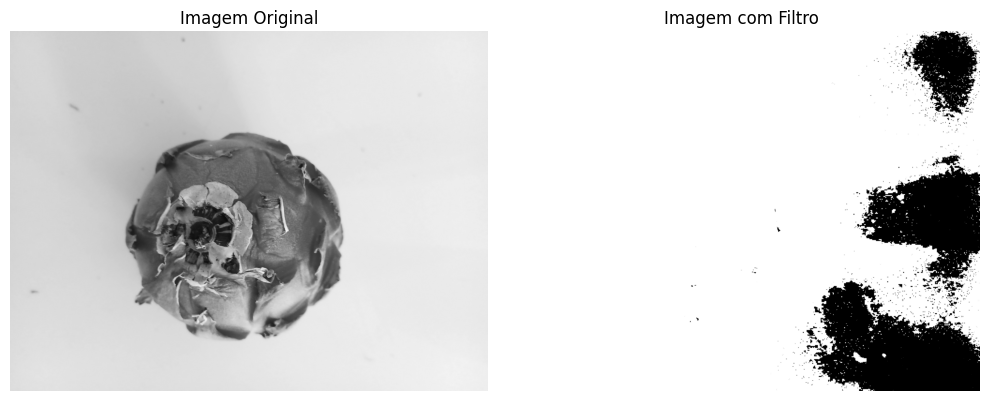

In [11]:
dados = []
th = -1
maior_frequencia = 0

for i in range(256):
    porcentagem = hist.probabilidade[i] * 100
    if 5 <= porcentagem <= 10:
        if hist.histograma[i] > maior_frequencia:
            maior_frequencia = hist.histograma[i]
            th = i
        dados.append([f"Nível de cinza {i}", i, f"{porcentagem:.2f}%"])
binarizacaoIMG(image, th)

* **THRESHOLDING PELO MÉTODO DOS DOIS PICOS**

---

In [12]:
def funcao_dois_picos(histograma):
    pico_max = max(range(len(histograma.histograma)), key=lambda i: histograma.histograma[i])
    lista_seg_pico = [
        ((i - pico_max) ** 2) * freq for i, freq in enumerate(histograma.histograma)
    ]

    seg_pico_max = lista_seg_pico.index(max(lista_seg_pico))
    inicio = min(pico_max, seg_pico_max)
    fim = max(pico_max, seg_pico_max)
    limiar = min(range(inicio, fim + 1), key=lambda i: histograma.histograma[i])

    return limiar

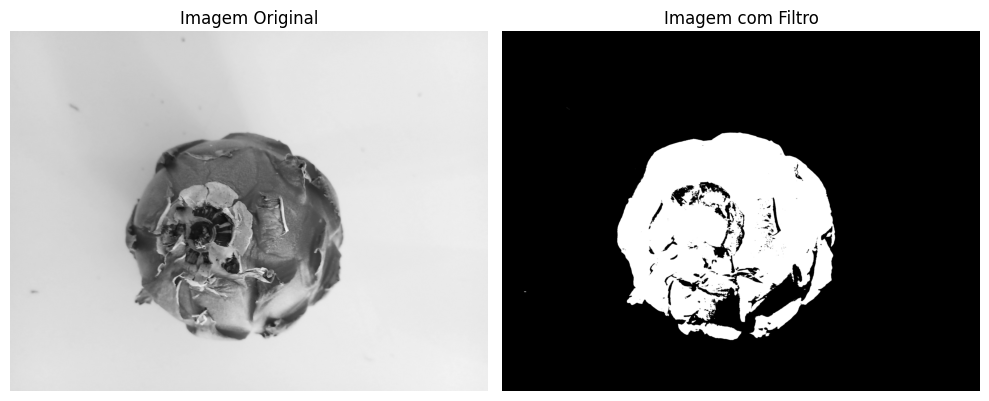

In [13]:
hist = CalcHistograma(image)
hist.start()
limiar = funcao_dois_picos(hist)
binarizacaoIMG(image, limiar)

* **THRESHOLDING PELO MÉTODO DE OTSU**

---

In [ ]:
def otsu_threshold_detalhado(hist):
    histograma = hist.histograma
    total_pixels = sum(histograma)

    p = histograma / total_pixels

    niveis = np.arange(256)
    mu_t = np.sum(niveis * p)

    var_intra_max = float('inf')
    t_otimo = 0
    variancias_intra = []

    for t in range(256):
        w0 = np.sum(p[:t+1])
        w1 = np.sum(p[t+1:])

        if w0 == 0 or w1 == 0:
            variancias_intra.append(float('inf'))
            continue

        mu_t_t = np.sum(niveis[:t+1] * p[:t+1])
        mu0 = mu_t_t / w0
        mu1 = (mu_t - mu_t_t) / w1
        var_entre = w0 * w1 * (mu0 - mu1) ** 2
        var_total = np.sum((niveis - mu_t) ** 2 * p)
        var_intra = var_total - var_entre
        variancias_intra.append(var_intra)

        if var_intra < var_intra_max:
            var_intra_max = var_intra
            t_otimo = t

    return t_otimo


In [ ]:
hist = CalcHistograma(image)
hist.start()

th_otsu = otsu_threshold_detalhado(hist)

binarizacaoIMG(image, th_otsu)

Conclusão:  No contexto das imagens utilizadas (fotos de pitaya), o método de segmentação por percentil não apresentou resultados satisfatórios. Isso se deve ao fato de que esse método aplica um limiar fixo com base em uma fração do histograma, sem levar em consideração a distribuição real dos tons de cinza da imagem. Como resultado, especialmente em imagens onde a pitaya ocupa uma área relativamente pequena em comparação com o fundo, o limiar definido não foi eficaz para separar objeto e fundo. Dessa forma, a segmentação resultante não permitiu distinguir de forma clara a fruta do restante da imagem.

Por outro lado, os métodos dos dois picos e o método de Otsu apresentaram desempenho significativamente superior. Ambos analisam a distribuição global dos níveis de intensidade da imagem: o método dos dois picos identifica os dois principais picos no histograma e define o limiar entre eles, enquanto o método de Otsu determina o limiar que maximiza a separação entre classes, minimizando a variância intra-classe. Essa abordagem se mostrou mais adequada para as imagens de pitaya, pois conseguiu identificar de forma mais precisa as regiões relevantes da fruta mesmo em meio a variações de iluminação ou contraste.

A diferença entre os dois métodos foi mínima. Os limiares obtidos foram bastante próximos — 130 para o método dos dois picos e 127 para o de Otsu — e as imagens segmentadas apresentaram resultados visuais quase idênticos, com diferenças praticamente imperceptíveis. Isso evidencia que ambos os métodos são eficazes para a segmentação da pitaya, sendo muito superiores ao método baseado em percentil para esse tipo de imagem.

* **MÉTODO DE BERNSEN**

---

In [16]:
def metodo_bernsen(image, limiar):
    img_copy = image.copy()
    altura, largura = img_copy.shape

    for i in range(1, altura - 1):
        for j in range(1, largura - 1):
            P = int(image[i, j])
            N = int(image[i-1, j])
            S = int(image[i+1, j])
            E = int(image[i, j+1])
            O = int(image[i, j-1])
            NE = int(image[i-1, j+1])
            NO = int(image[i-1, j-1])
            SE = int(image[i+1, j+1])
            SO = int(image[i+1, j-1])

            vizinhanca_8 = np.array([P, N, S, E, O, NE, NO, SE, SO])

            maximo = np.max(vizinhanca_8)
            minimo = np.min(vizinhanca_8)
            media_max_min = (maximo + minimo) / 2

            if media_max_min > limiar:
                img_copy[i, j] = 0
            else:
                img_copy[i, j] = 255

    return img_copy

def binarizacaoIMG(image, limiar):
    img_binarizada = metodo_bernsen(image, limiar)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Imagem Original')
    axes[0].axis('off')
    axes[1].imshow(img_binarizada, cmap='gray')
    axes[1].set_title('Imagem Binarizada')
    axes[1].axis('off')
    plt.show()

In [ ]:
binarizacaoIMG(image, limiar=120)

* **MÉTODO DAS MÉDIAS MÓVEIS**

---

In [ ]:
def binarizacao_media_movel(image, n):
    altura, largura = image.shape
    img_bin = np.zeros_like(image, dtype=np.uint8)

    for i in range(altura):
        linha = image[i, :]
        media = np.zeros_like(linha, dtype=np.float32)
        soma = np.sum(linha[:n])
        media[n - 1] = soma / n

        for j in range(n, largura):
            soma = soma - linha[j - n] + linha[j]
            media[j] = soma / n

        for j in range(largura):
            if image[i, j] > media[j]:
                img_bin[i, j] = 255
            else:
                img_bin[i, j] = 0

    return img_bin
def mostrar_binarizacao(original, binarizada):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Imagem Original')
    axes[0].axis('off')
    axes[1].imshow(binarizada, cmap='gray')
    axes[1].set_title('Imagem Binarizada')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

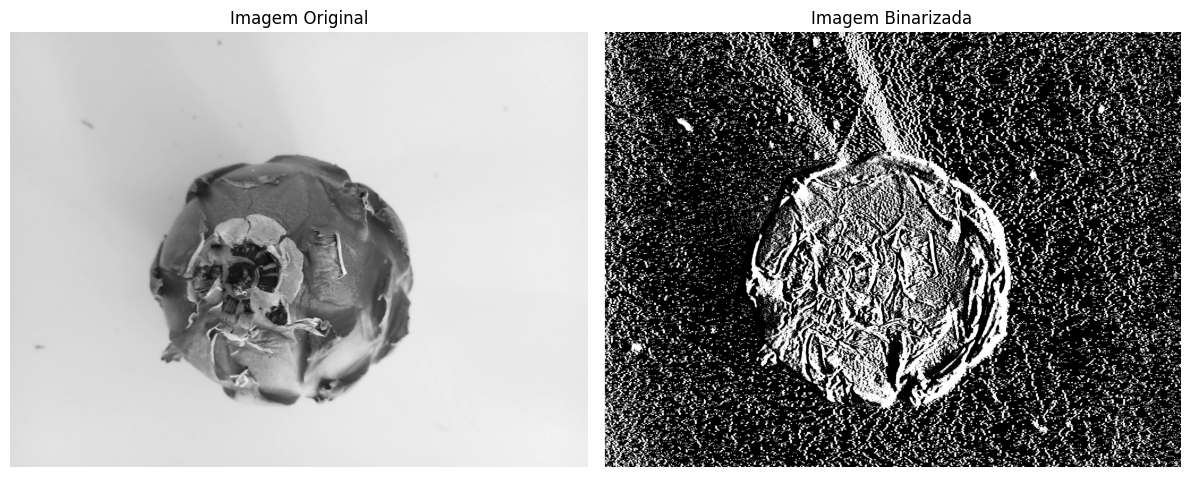

In [19]:
imagem_np = np.array(image)
binarizada = binarizacao_media_movel(imagem_np, n=15)
mostrar_binarizacao(imagem_np, binarizada)

Conclusão: Após a aplicação dos dois métodos à base de imagens de pitaya, é possível observar diferenças significativas em seus desempenhos. O Método de Bernsen apresentou baixa precisão na segmentação, dificultando a distinção entre o objeto de interesse e o fundo. Essa limitação pode ser atribuída à sua dependência do contraste local, que, em regiões com variações sutis de intensidade — comuns nas imagens analisadas —, compromete a definição dos contornos do objeto. Além disso, esse método apresentou um tempo de execução relativamente elevado, possivelmente devido ao cálculo intensivo de máximos, mínimos e contrastes dentro de janelas locais.

Em contrapartida, o Método das Médias Móveis obteve um desempenho superior na separação entre o objeto (pitaya) e o fundo. Isso se deve, em parte, à suavização proporcionada pela média dos pixels, que reduz o impacto de ruídos e texturas irregulares presentes no fundo das imagens. Como resultado, o objeto se destaca de forma mais clara, embora ainda sejam perceptíveis alguns ruídos residuais na imagem segmentada. Além disso, esse método demonstrou maior eficiência computacional, com um tempo de execução reduzido em comparação ao de Bernsen, o que reforça sua viabilidade para aplicações em tempo real ou em grandes volumes de dados.


---



Conclusão Geral:
As principais diferenças entre os métodos residem na forma como o limiar é determinado (global ou local), na robustez diante de variações de iluminação e na capacidade de lidar com ruídos e texturas. Métodos como Otsu e Dois Picos funcionam bem quando a imagem tem histogramas bem definidos, enquanto métodos locais como Bernsen e Médias Móveis se destacam em imagens com iluminação não uniforme. No caso específico das imagens de pitaya, o Método das Médias Móveis ofereceu o melhor equilíbrio entre separação de objeto e fundo, presença de ruídos e eficiência de processamento.

* **ROBERTS**

---

In [ ]:
def aplicar_roberts_cross(img):
    roberts_cross_v = np.array([[1, 0],[0, -1]], dtype=np.float32)

    roberts_cross_h = np.array([[0, 1],[-1, 0]], dtype=np.float32)

    img_norm = img.astype(np.float32) / 255.0

    vert = cv2.filter2D(img_norm, -1, roberts_cross_v)
    hori = cv2.filter2D(img_norm, -1, roberts_cross_h)
    edged_img = np.sqrt(np.square(hori) + np.square(vert))

    edged_img *= 255
    edged_img = np.clip(edged_img, 0, 255).astype(np.uint8)

    plot_images(img, edged_img)
aplicar_roberts_cross(image)

* **SOBEL**

---

In [ ]:
def aplicar_prewitt(img_gray):
    img_copy = img_gray.copy().astype(np.float64)

    prewittX = np.array([[1, 1, 1],[0, 0, 0],[-1, -1, -1]])
    prewittY = np.array([[-1, 0, 1],[-1, 0, 1],[-1, 0, 1]])

    Gx = cv2.filter2D(img_copy, -1, prewittX)
    Gy = cv2.filter2D(img_copy, -1, prewittY)

    img_prewitt = Gx + Gy
    img_prewitt_uint8 = cv2.convertScaleAbs(img_prewitt)

    plot_images(img_gray, img_prewitt_uint8)
aplicar_prewitt(image)

* **PREWITT**

---

In [ ]:
import cv2
import numpy as np

def aplicar_prewitt(img):
    img_copy = img.copy().astype(np.float64)

    prewittX = np.array([[1, 0, -1],[2, 0, -2],[1, 0, -1]])
    prewittY = np.array([[1, 2, 1],[0, 0, 0],[-1, -2, -1]])

    Gx = cv2.filter2D(img_copy, -1, prewittX)
    Gy = cv2.filter2D(img_copy, -1, prewittY)

    magnitude = np.sqrt(np.square(Gx) + np.square(Gy))
    img_prewitt_uint8 = cv2.convertScaleAbs(magnitude)

    plot_images(img, img_prewitt_uint8)
aplicar_prewitt(image)

Conclusão: No contexto das imagens das pitayas, os três filtros Roberts, Sobel e Prewitt foram capazes de destacar o objeto em relação ao fundo. No entanto, o filtro Prewitt apresentou o melhor desempenho, evidenciando o objeto de forma mais nítida e com melhor definição das bordas. Esse resultado pode ser atribuído à maior suavidade do operador Prewitt, que utiliza máscaras de convolução com coeficientes uniformes, o que o torna menos sensível ao ruído em comparação ao filtro Roberts e mais equilibrado em relação ao filtro Sobel. Isso contribui para uma segmentação mais limpa e precisa das bordas do objeto nas imagens analisadas.

* **LAPLACIANO**

---

In [ ]:
import cv2
import numpy as np

def aplicar_laplaciano(img_gray):
    laplaciano_kernel = np.array([[0, -1, 0],[-1, 4, -1],[0, -1, 0]])


    img_copy = img_gray.copy().astype(np.float64)
    laplaciano = cv2.filter2D(img_copy, -1, laplaciano_kernel)
    resultado = cv2.convertScaleAbs(laplaciano)

    plot_images(img_gray, resultado)
aplicar_laplaciano(image)

* **LAPLACIANO DO GAUSSIANO (LOG)**

---

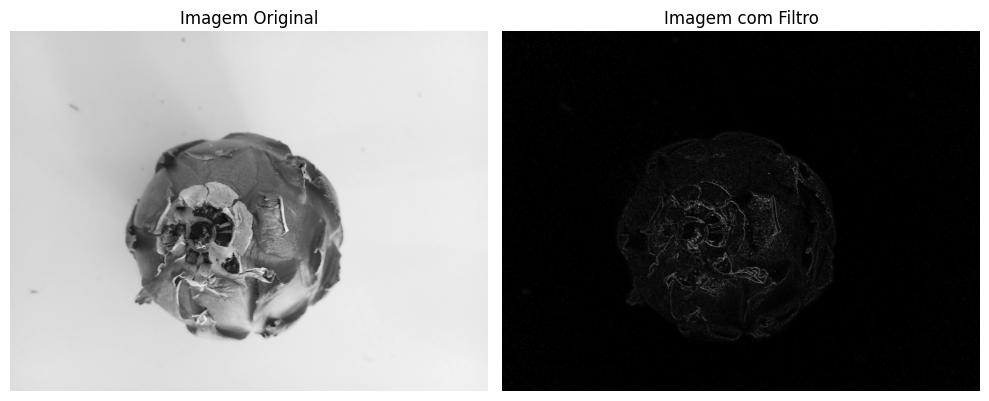

In [24]:
def aplicar_laplaciano_gaussiano(img_gray):
    kernel = np.array([
        [ 0,  0,  -1,  0,  0],
        [ 0, -1,  -2, -1,  0],
        [-1, -2,  16, -2, -1],
        [ 0, -1,  -2, -1,  0],
        [ 0,  0,  -1,  0,  0]
    ])

    img_copy = img_gray.copy().astype(np.float64)
    resultado = cv2.filter2D(img_copy, -1, kernel)
    resultado_uint8 = cv2.convertScaleAbs(resultado)

    plot_images(img_gray, resultado_uint8)
aplicar_laplaciano_gaussiano(image)

* **DIFERENÇA DE GAUSSIANAS (DOG)**

---

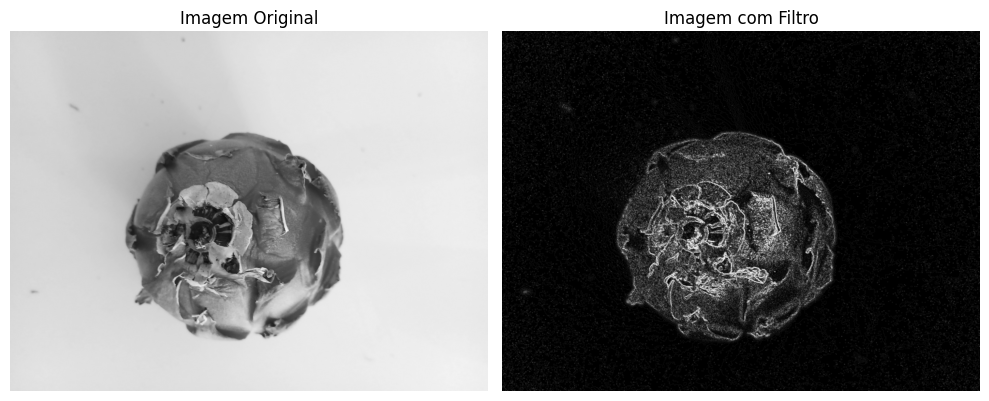

In [25]:
def diferenca_gaussianos(img_gray):
    kernel = np.array([
        [0,  0,  -1,  -1, -1, 0,  0],
        [0,  -2,  -3,  -3, -3, -2,  0],
        [-1,  -3,   5,   5,  5, -3, -1],
        [-1,  -3,   5,  16,  5, -3, -1],
        [-1,  -3,   5,   5,  5, -3, -1],
        [0,  -2,  -3,  -3, -3, -2,  0],
        [0,   0,  -1,  -1, -1,  0,  0]
    ])

    img_copy = img_gray.copy().astype(np.float64)
    resultado = cv2.filter2D(img_copy, -1, kernel)
    resultado_uint8 = cv2.convertScaleAbs(resultado)

    plot_images(img_gray, resultado_uint8)
diferenca_gaussianos(image)

Conclusão: No contexto das imagens das pitayas, os três filtros Laplaciano, Laplaciano do Gaussiano e Diferença de Gaussianas foram eficazes em destacar o objeto em relação ao fundo. Embora o filtro Diferença de Gaussianas tenha proporcionado maior nitidez na separação entre o objeto e o fundo, foi também o que introduziu mais ruídos na imagem. Esse comportamento pode ser explicado pela natureza do filtro, que realça as regiões de transição abrupta de intensidade, sendo mais sensível a variações locais, inclusive aquelas causadas por ruídos. Em contrapartida, o filtro Laplaciano do Gaussiano, ao combinar suavização e detecção de bordas, oferece um melhor equilíbrio entre nitidez e redução de ruído, sendo mais apropriado quando se busca uma segmentação com menor interferência visual.


---



Conclusão Geral: Os filtros Roberts, Sobel e Prewitt (de primeira ordem) e Laplaciano, Laplaciano do Gaussiano e Diferença de Gaussianas (de segunda ordem) apresentaram desempenhos distintos na detecção das bordas das pitayas. O filtro Prewitt se destacou entre os de primeira ordem por evidenciar bem o objeto com pouco ruído. Já entre os de segunda ordem, a Diferença de Gaussianas gerou maior nitidez, mas introduziu mais ruídos, enquanto o Laplaciano do Gaussiano ofereceu um equilíbrio melhor entre definição e suavização. As diferenças se devem à natureza matemática dos filtros e à forma como lidam com variações de intensidade e ruídos na imagem.